# CityU EE4016: Engineering Applications of Artificial Intelligence


## PyTorch Multi-Layer Perceptron (MLP) Image Classifier With Fashion MNIST Dataset

In this example, we will train an MLP model to classify images from the Fashion MNIST database.

The Fashion MNIST dataset is a widely used dataset in Deep Learning for training and testing various algorithms. It was created as a replacement for the original handwritten digits MNIST dataset to provide a more challenging classification task.

Here are some key details about the Fashion MNIST dataset:
- The dataset consists of 70,000 grayscale images of fashion products from 10 different categories
- Each image is a 28x28 pixel square
- The dataset consists of a training dataset of 60,000 images and a test dataset of 10,000 images
- In this example, the test dataset is divided into validation and test sets, each containing 5,000 samples.

The goal is to classify each image into one of the 10 fashion categories, such as T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_fmnist.png'>


References:
- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)

- Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist

# Assignment 1: Report

Provide your assignment report here. Write an abstract analyzing the model architecture, training process, experiments, results and evaluation conclusions. Discuss which techniques work well and how you could improve the baseline model. Include relevant visualizations.


# Abstract
<pre>
Architecture
    - The MLP model have 4 hidden layer
        > 784 inputs
        > layer 1: 300 neurons
        > layer 2: 100 neurons
        > layer 3: 50 neurons
        > output layer: 10 outputs
        * I tried several combination of layers and neurons, and base on the current situation, 
        the performance of deeper network didn't show a improvement on test accuracy, or even worser 
        due to the overfitting problem. And current combination is the best that I have tried.

    - activation function: Swish (SiLU)
        * I tried a bunch of activation function inclued Tanh, ReLU, LeakyReLU, SELU, GELU and SiLU. 
        And the performance of SiLU is relatively better than other in the same training way. The output activation function is log softmax.

    - Initialization: Kaiming normal
        * i use He initialization for LeakyReLU function and found that it is quite suitable for SiLU too, so i keep it.

    - Batch Normalization: apply on layer 1,2,3 and before activation
        * Having better performance than after activation

    - Dropout with 0.1 probability
        * As I want to make sure the test accuracy, i didnt set a very high dropout probability. 
        Other probability that higher than 0.1 may lower the accuracy.

    - Optimization function: Adam with default setting

    - Loss function: Cross Entropy Loss

Training process
    - Data augmentation:
        * I only add random horizontal flip, as i found that other transform is not suitable for the training image and test set.

Result
    - Highest training accuracy: 95.14%
    - Highest valuation accuracy: 91.4%
    - <b>Test accuracy : 91.2%</b>

Conclusion: The model performance is quite good. Having test accuracy 91.2%, 
            while having 4 layer and 272060 parameters. The complexity of the model architecture is not high but can achieve a high accuracy.


    

# Starting of your code

In [2]:
# Import the necessary libraries for working with Fashion-MNIST dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [3]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 11, 8)
PyTorch version: 2.2.0+cu118
Device: cuda


In [4]:
# Set seed for reproducibility
# Use your student as the seed for assignment submission
seed = 57155082
torch.manual_seed(seed)

# Download Fashion MNIST Dataset

This code snippet creates DataLoaders to facilitate the downloading of the training and test sets. The Fashion MNIST training dataset, consisting of 60,000 samples, is used to train the Model. The test dataset is randomly split into a validation set and a test set, each containing 5,000 samples. The data loaders are employed to provide batches of data from the datasets for iteration. The training data comprises batches of images, with each image measuring 28 x 28 pixels. The corresponding labels indicate the correct Fashion labels ("T-shirt," "Trouser," "Pullover," etc.) for each image.


In [4]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
     transforms.RandomHorizontalFlip(0.2),
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.5,), (0.5,))])  # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.5,), (0.5,))])  # Normalize the image data

# Create the Fashion MNIST dataset for the training set with 60,000 images
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)

# Create the Fashion MNIST dataset for the test set with 10,000 images
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)
# Define the classes for the Fashion MNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##Visualize image for each class
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

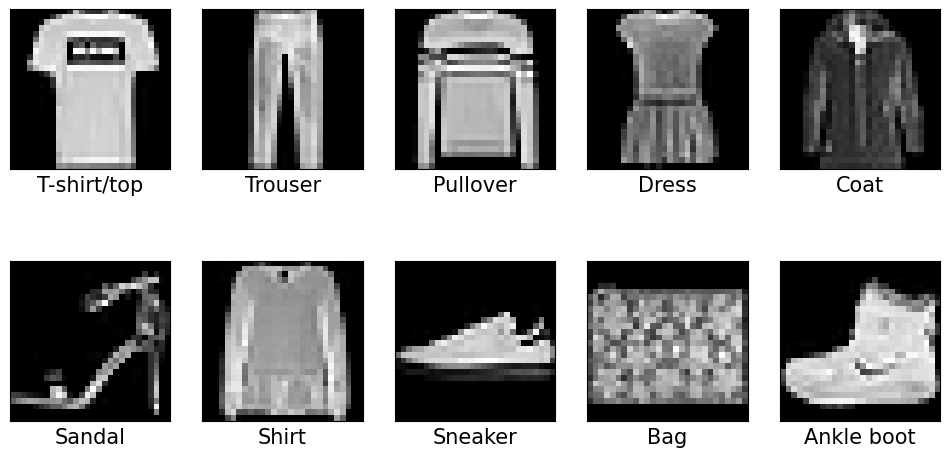

In [5]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i], cmap='gray')
    i += 1

# Define the MLP Network Architecture

The following code defines a class called MLPNet which inherits from nn.Module. The network has 4 fully-connected layers:

- fc1 takes the 784-pixel Fashion MNIST image as input and outputs 300 nodes
- fc2 takes the 300 nodes and outputs 100 nodes
- fc3 takes the 300 nodes and outputs 50 nodes
- fc4 takes the 50 nodes and outputs predictions for the 10 classes

The forward method defines the forward pass through the network. It applies Swish activation on the first three layers and log softmax on the output layer.

In [6]:
## Define the MLP architecture

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784,300)
        self.fc2 = nn.Linear(300,100)
        self.fc3 = nn.Linear(100,50)
        self.fc4 = nn.Linear(50,10)

        self.bn1 = nn.BatchNorm1d(300)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(50)

        self.dropout = nn.Dropout(0.1)
        
        self.activation = nn.SiLU()
        nn.init.kaiming_normal_(self.fc1.weight, a=0.01, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc2.weight, a=0.01, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc3.weight, a=0.01, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc4.weight, a=0.01, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        x = x.view(-1, 784)
        
        x = self.dropout(x)
        x = self.activation(self.bn1(self.fc1(x)))

        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))

        x = self.dropout(x)
        x = self.activation(self.bn3(self.fc3(x)))

        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

model = MLP()

summary(model=MLP(), input_size=(1, 1, 28, 28), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
MLP (MLP)                                [1, 1, 28, 28]  [1, 10]         --              True
├─Dropout (dropout)                      [1, 784]        [1, 784]        --              --
├─Linear (fc1)                           [1, 784]        [1, 300]        235,500         True
├─BatchNorm1d (bn1)                      [1, 300]        [1, 300]        600             True
├─SiLU (activation)                      [1, 300]        [1, 300]        --              --
├─Dropout (dropout)                      [1, 300]        [1, 300]        --              --
├─Linear (fc2)                           [1, 300]        [1, 100]        30,100          True
├─BatchNorm1d (bn2)                      [1, 100]        [1, 100]        200             True
├─SiLU (activation)                      [1, 100]        [1, 100]        --              --
├─Dropout (dropout)                      [1, 100]        [1, 10

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation, you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [7]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify Adam optimizer with defualt setting
optimizer = optim.Adam(model.parameters())

##Training the Network
The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [8]:
# Create a Models folder to store the checkpoints
!mkdir ModelsY

In [9]:
EPOCHS = 100

loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_val, acc_hist_val = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(batch)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)  # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0

        # Validation loop
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

        avg_loss_val = loss_val / len(val_set)  # Average validation loss for the epoch
        avg_acc_val = correct_val / len(val_set)  # Average validation accuracy for the epoch
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)

    model.train()  # Set the model back to training mode
    
    # Save the model at the end of each epoch
    with open("ModelsY/MLP_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Val Loss: {:.3f}".format(avg_loss_val * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Val Accuracy: {:.2f}%".format(avg_acc_val * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


Training was started.

EPOCH: 1 

Train Loss: 0.250 Val Loss: 0.173 Train Accuracy: 79.80% Val Accuracy: 84.42% Time: 6.62s 
EPOCH: 2 Train Loss: 0.164 Val Loss: 0.153 Train Accuracy: 84.94% Val Accuracy: 85.76% Time: 5.71s 
EPOCH: 3 Train Loss: 0.149 Val Loss: 0.146 Train Accuracy: 86.07% Val Accuracy: 86.70% Time: 5.78s 
EPOCH: 4 Train Loss: 0.138 Val Loss: 0.135 Train Accuracy: 86.97% Val Accuracy: 87.38% Time: 5.93s 
EPOCH: 5 Train Loss: 0.132 Val Loss: 0.130 Train Accuracy: 87.47% Val Accuracy: 88.02% Time: 5.59s 
EPOCH: 6 Train Loss: 0.129 Val Loss: 0.135 Train Accuracy: 87.86% Val Accuracy: 87.88% Time: 5.75s 
EPOCH: 7 Train Loss: 0.124 Val Loss: 0.130 Train Accuracy: 88.26% Val Accuracy: 88.00% Time: 5.71s 
EPOCH: 8 Train Loss: 0.120 Val Loss: 0.126 Train Accuracy: 88.49% Val Accuracy: 88.08% Time: 6.01s 
EPOCH: 9 Train Loss: 0.116 Val Loss: 0.131 Train Accuracy: 88.94% Val Accuracy: 88.22% Time: 5.47s 
EPOCH: 10 Train Loss: 0.114 Val Loss: 0.124 Train Accuracy: 89.08% Val Accuracy: 88.56% Time: 5.68s 
EPOCH: 1

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

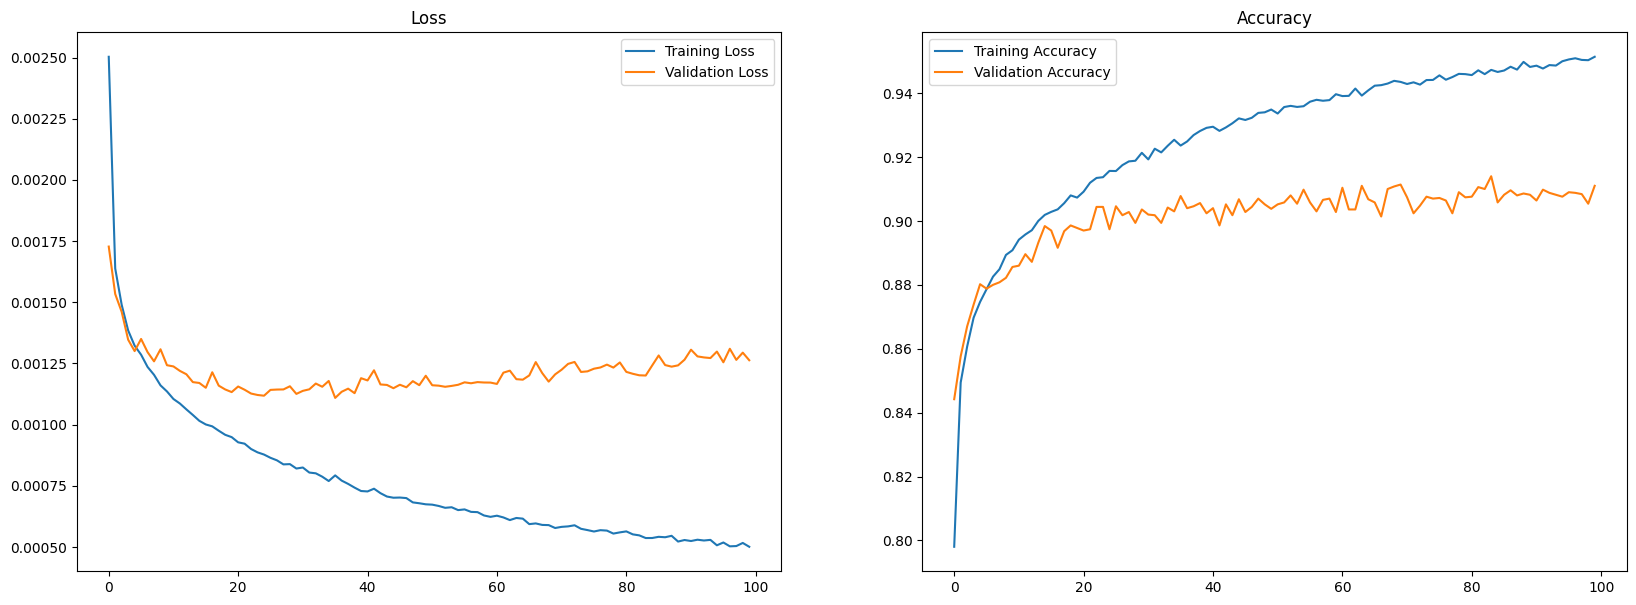

In [10]:
plots=[(loss_hist,loss_hist_val),(acc_hist,acc_hist_val)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

##Save the best trained model

In [11]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc)+1

print("Best accuracy on validation set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"ModelsY/MLP_model_{best_epoch}.pth","rb") as f:
    loaded_model=pickle.load(f)

model = loaded_model

Best accuracy on validation set: 91.40%
Best epoch: 84


#Compute Test Set Accuracy using the Trained Model

While it is important to achieve high training and validation accuracy, these metrics can sometimes be deceptive due to overfitting. On the other hand, the test accuracy provides a more reliable assessment of how well the model performs on new, unseen data, which is crucial for real-world applications.

Hence, it is essential to evaluate the performance of our best model by testing it on previously unseen data. This allows us to determine how effectively the model generalizes. Furthermore, **in the marking scheme of Assignment 1, emphasis is placed primarily on the test set accuracy of the model**, rather than the training or validation accuracy.



In [12]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
model.to(device)

with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

print("Test Loss: {:.2f}".format(test_loss))
print('Test set Accuracy on the 5,000 test images: %.2f %%' % (100 * correct / len(test_set)))

Test Loss: 0.48
Test set Accuracy on the 5,000 test images: 91.20 %


# Display the Confusion Matrix

In [13]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,442,0,5,5,4,1,45,0,3,0
Trouser,3,487,0,3,2,0,3,0,0,0
Pullover,10,0,451,2,40,0,26,0,2,0
Dress,8,3,8,436,14,0,8,0,1,0
Coat,0,0,23,11,441,0,26,0,3,0
Sandal,0,0,0,0,0,491,0,10,0,6
Shirt,52,0,26,11,28,0,358,0,3,0
Sneaker,0,0,0,0,0,4,0,492,0,10
Bag,4,0,1,0,0,1,1,2,482,0
Ankle boot,0,0,0,0,0,6,0,16,0,480


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [14]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,T-shirt/top,0.863281,0.875248,0.851638,519.000
1,Trouser,0.985830,0.977912,0.993878,490.000
2,Pullover,0.863158,0.849341,0.877432,514.000
3,Dress,0.921776,0.912134,0.931624,468.000
4,Coat,0.853824,0.875000,0.833648,529.000
5,Sandal,0.972277,0.968442,0.976143,503.000
6,Shirt,0.757672,0.748954,0.766595,467.000
7,Sneaker,0.959064,0.972332,0.946154,520.000
8,Bag,0.978680,0.981670,0.975709,494.000
9,Ankle boot,0.961924,0.956175,0.967742,496.000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.

# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

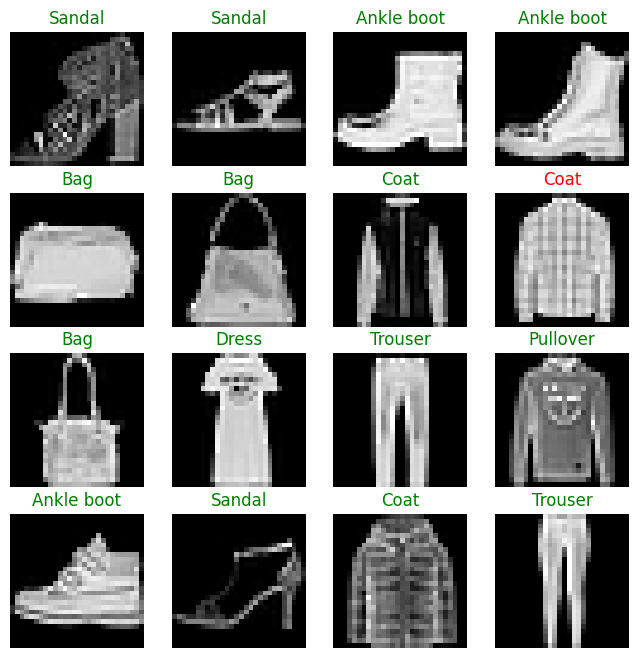

In [15]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image, cmap='gray')  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

#Display 50 Predicted Images in Reversed Grayscale
We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.

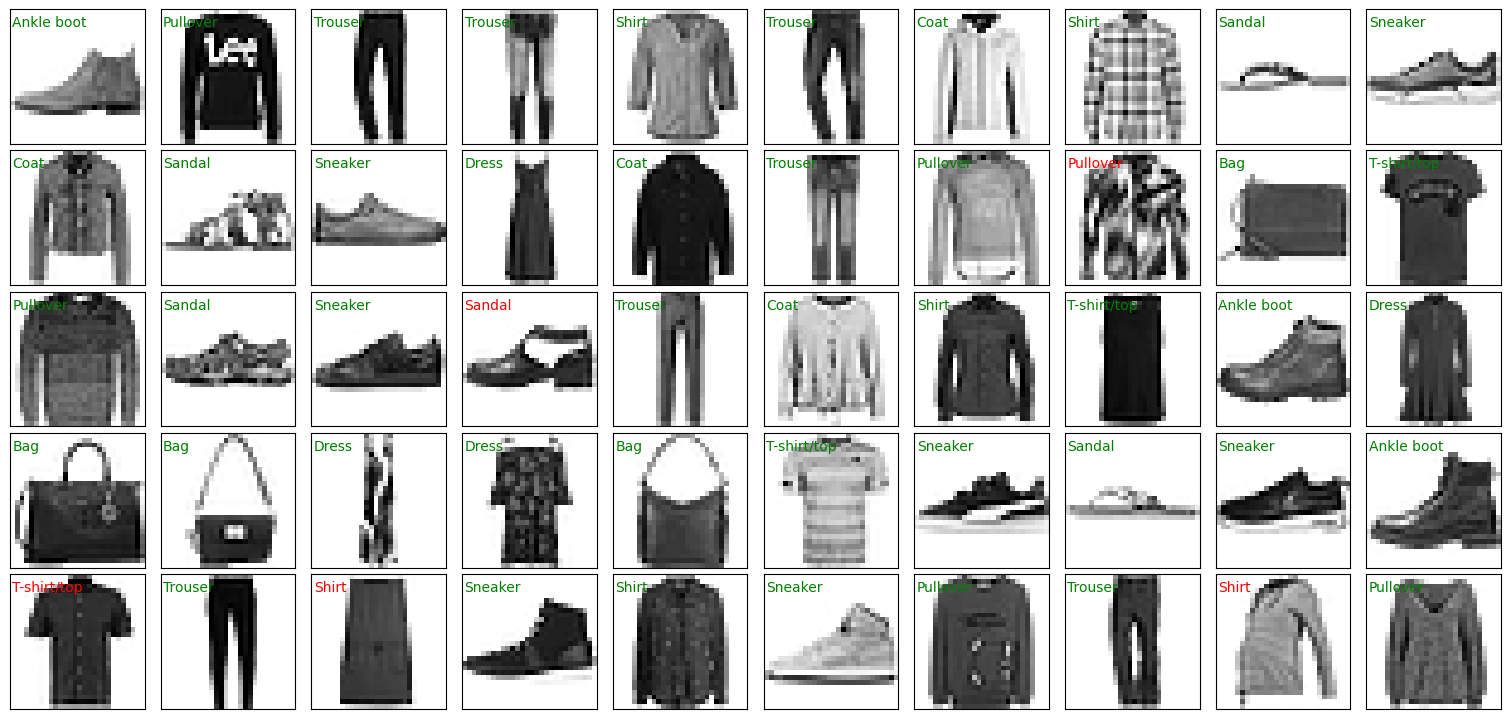

In [16]:
# Define the loader for all test data
test_set_all = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()


#Visualize wrongly classified image for each class

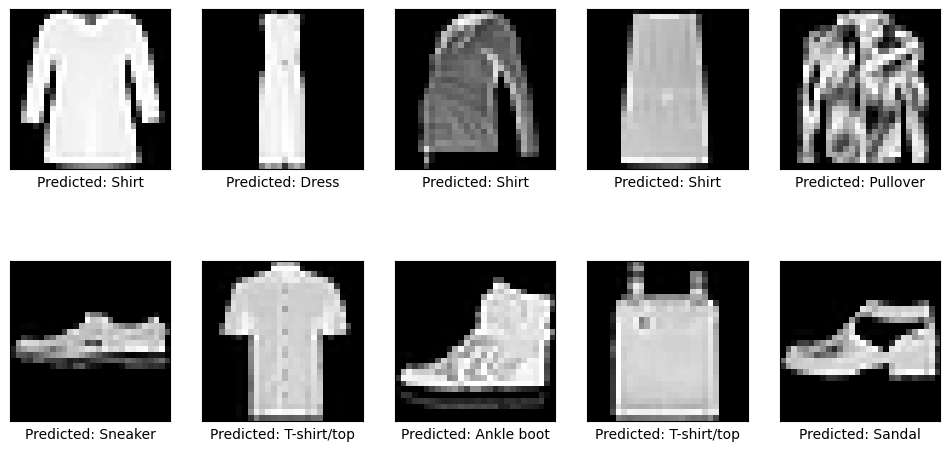

In [17]:
# Visualize wrongly classified image for each class

pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1